In [1]:
import os
import glob
import numpy as np
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from scipy.ndimage import gaussian_filter1d
from scipy import stats
import statsmodels.formula.api as smf
import scipy.signal as sig

sns.set_context('poster')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# import Python3_OpenOE_AC_map_functions_v1_08_30s as oem
import mz_LFP_functions as mz_LFP

import Python3_icsd as icsd 
import scipy.signal as sg
import quantities as pq

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcdefaults()

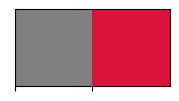

In [3]:
pal=sns.blend_palette(['gray','crimson'],2)
sns.palplot(pal)
sns.set_palette(pal)

# Load some necessary variables

In [4]:
insert_depth = 3100  #change this as appropriate

sp_bw_ch = 20/2

surface_ch = np.round(insert_depth/sp_bw_ch)
V1_hip_ch = np.round((insert_depth-1100)/sp_bw_ch)
Hip_thal_ch = np.round((insert_depth-1100-1200)/sp_bw_ch)

CA1_DG_ch = np.round((insert_depth-1100-600)/sp_bw_ch)

print(surface_ch, V1_hip_ch, Hip_thal_ch, CA1_DG_ch)

310.0 200.0 80.0 140.0


In [5]:
samples_tr = 7350 #this is based on the shortest #samples in a trial
sr = 2500
n_chan = 384
rec_length = 3.0 #how long is the arduino triggered?

---

# First, load in the .npy arrays and CC_ls
These were creaded and saved using the "1_saving_LFP_arrays" jupyter notebook

In [6]:

# all_post_arr = np.load(r"D:\")


In [7]:
# pkl_file = r"D:\"

open_file = open(pkl_file, "rb")
et_ls_post = pickle.load(open_file)
open_file.close()

print(et_ls_post)

['CC082263HP1', 'CC082263HP2', 'CC082263HP3', 'CC084621HP1', 'CC084621HP2', 'CC067489HP2', 'CC067489HP3', 'CC082260HP2', 'CC082260HP3', 'CC082260HP4']


---

# Test the shape of the arrays
this should be -- # mice x # trials x # channels x # samples

In [8]:

print('Training: {}'.format(all_post_arr.shape))


Training: (10, 48, 384, 7350)


---

In [9]:
def butter_bandpass_filter(data, lowcutoff=4, highcutoff=8, fs=2500, order=6):
    nyq = 0.5 * fs  # Nyquist Frequency
    high_cutoff = highcutoff / nyq
    low_cutoff = lowcutoff / nyq
    # Get the filter coefficients 
    b, a = sig.butter(order, high_cutoff, btype='low', analog=False)
    y = sig.filtfilt(b, a, data)
    b2, a2 = sig.butter(order, low_cutoff, btype='high', analog=False)
    y2 = sig.filtfilt(b2, a2, y)
    return y2

# Plot LFP for V1 and HPC at specific trials

In [10]:
def find_vep_ch(mouse):
    tmp2 = np.mean(mouse, axis = 0)           # getting the mean traces over all trials
    v1_chs = tmp2[200:300,:]
    min_ch = np.where(v1_chs == np.amin(v1_chs))
    min_ch2 = min_ch[0][0] + 199
    return min_ch2

In [11]:
#this is plotting the average VEP across mice (can be changed to each mouse)

chs_ls = []
for idx, mouse in enumerate(all_post_arr):
    tmp2 = np.mean(mouse, axis = 0)           # getting the mean traces over all trials
    v1_chs = tmp2[200:300,:]
    min_ch = np.where(v1_chs == np.amin(v1_chs))
    min_ch2 = min_ch[0][0] + 199
    vep_ch = tmp2[min_ch2,:]
    chs_ls.append(vep_ch)
#     ---------------------------------------------------------------
v1_veps = np.array(chs_ls)
avg_plot_mean = np.mean(v1_veps, axis=0)
avg2_plot_mean = np.reshape(avg_plot_mean,(1,len(avg_plot_mean)))

# time_arr2_A = np.linspace(0, avg_plot_mean.shape[0]/sr, avg_plot_mean.shape[0])
# plt.plot(time_arr2_A, avg_plot_mean, label='WT', color='grey')
# plt.show()

# Now plot the traces alltogether 

In [1]:
# rep_dir = r'C:\'
# save_plots = 1
# colormap='jet'

# tr_a = 1
# tr_b = 15
# hpc_chx = 145
# hpc_chy = 120

# fs=2500
# order=6
# lowcutoff = 4
# highcutoff = 8
# lowcutoff2 = 30
# highcutoff2 = 80

# plt_labels = [0,0.5*sr,1*sr,1.5*sr,2*sr,2.5*sr]

# for idx, mouse in enumerate(all_post_arr):
#     mouse_et = et_ls_post[idx]
#     tot_trials = mouse.shape[0]
#     mouse_et = et_ls_post[idx]
#     #HPC lfp traces
#     trial_a = mouse[tr_a,:,:]
#     trial_b = mouse[tr_b,:,:]
#     hpc_tra_chx = trial_a[hpc_chx,:]
#     hpc_tra_chy = trial_a[hpc_chy,:]
#     hpc_trb_chx = trial_b[hpc_chx,:]
#     hpc_trb_chy = trial_b[hpc_chy,:]
#     filt_hpc_tra_chx = butter_bandpass_filter(hpc_tra_chx, lowcutoff, highcutoff, fs, order)
#     filt_hpc_tra_chy = butter_bandpass_filter(hpc_tra_chy, lowcutoff, highcutoff, fs, order)
#     filt_hpc_trb_chx = butter_bandpass_filter(hpc_trb_chx, lowcutoff, highcutoff, fs, order)
#     filt_hpc_trb_chy = butter_bandpass_filter(hpc_trb_chy, lowcutoff, highcutoff, fs, order)
#     filt2_hpc_tra_chx = butter_bandpass_filter(hpc_tra_chx, lowcutoff2, highcutoff2, fs, order)
#     filt2_hpc_tra_chy = butter_bandpass_filter(hpc_tra_chy, lowcutoff2, highcutoff2, fs, order)
#     filt2_hpc_trb_chx = butter_bandpass_filter(hpc_trb_chx, lowcutoff2, highcutoff2, fs, order)
#     filt2_hpc_trb_chy = butter_bandpass_filter(hpc_trb_chy, lowcutoff2, highcutoff2, fs, order)
#     time_a_hpc = np.linspace(0, trial_a.shape[1]/sr, trial_a.shape[1])
#     time_b_hpc = np.linspace(0, trial_b.shape[1]/sr, trial_b.shape[1])
#     #All probe heatmaps - trials 1 and 15
#     lfp_trial1 = trial_a * 1E-3 * pq.mV
#     lfp_trial10 = trial_b * 1E-3 * pq.mV
#     cbar_val = abs(lfp_trial1).max()
#     #V1 vep channel for each trials
#     v1_ch = find_vep_ch(mouse)
#     trial_a_v1 = mouse[tr_a,v1_ch,:]
#     trial_b_v1 = mouse[tr_b,v1_ch,:]
#     filt_trial_a_v1 = butter_bandpass_filter(trial_a_v1, lowcutoff, highcutoff, fs, order)
#     filt_trial_b_v1 = butter_bandpass_filter(trial_b_v1, lowcutoff, highcutoff, fs, order)
#     filt2_trial_a_v1 = butter_bandpass_filter(trial_a_v1, lowcutoff2, highcutoff2, fs, order)
#     filt2_trial_b_v1 = butter_bandpass_filter(trial_b_v1, lowcutoff2, highcutoff2, fs, order)
#     #V1 trial averaged veps per mouse
#     v1_tr_avg_vep = v1_veps[idx]
#     time_v1 = np.linspace(0, v1_tr_avg_vep.shape[0]/sr, v1_tr_avg_vep.shape[0])
#     #----------------Plotting---------------------------
#     fig = plt.figure(figsize=(15,10))
#     ax1 = plt.subplot2grid((6, 3), (0, 0), rowspan=3)
#     ax2 = plt.subplot2grid((6, 3), (0, 1))
#     ax3 = plt.subplot2grid((6, 3), (1, 1), sharex=ax2)
#     ax4 = plt.subplot2grid((6, 3), (2, 1), sharex=ax2)
#     ax5 = plt.subplot2grid((6, 3), (3, 0), rowspan=3)
#     ax6 = plt.subplot2grid((6, 3), (3, 1))
#     ax7 = plt.subplot2grid((6, 3), (4, 1), sharex=ax6)
#     ax8 = plt.subplot2grid((6, 3), (5, 1))
#     ax9 = plt.subplot2grid((6, 3), (0, 2))
#     ax10 = plt.subplot2grid((6, 3), (1, 2))
#     ax11 = plt.subplot2grid((6, 3), (2, 2))
#     ax12 = plt.subplot2grid((6, 3), (3, 2))
#     ax13 = plt.subplot2grid((6, 3), (4, 2))
#     ax14 = plt.subplot2grid((6, 3), (5, 2))
    
#     ax1.imshow(lfp_trial1, origin='lower', vmin=-cbar_val, vmax=cbar_val, cmap=colormap, interpolation='nearest', aspect='auto')
#     ax1.axhline(y=hpc_chx, color='crimson')
#     ax1.axhline(y=hpc_chy, color='violet')
#     ax5.imshow(lfp_trial10, origin='lower', vmin=-cbar_val, vmax=cbar_val, cmap=colormap, interpolation='nearest', aspect='auto')
#     ax5.axhline(y=hpc_chx, color='crimson')
#     ax5.axhline(y=hpc_chy, color='violet')
    
# #     ax2.plot(time_v1, v1_tr_avg_vep,, color='cyan')
# #     ax6.plot(time_v1, v1_tr_avg_vep, color='cyan')
#     ax2.plot(time_v1, trial_a_v1, color='grey')
#     ax6.plot(time_v1, trial_b_v1, color='grey')
#     ax1.axhline(y=v1_ch, color='grey')
#     ax5.axhline(y=v1_ch, color='grey')
#     ax3.plot(time_a_hpc, hpc_tra_chx, color='crimson')
#     ax4.plot(time_a_hpc, hpc_tra_chy, color='violet')
#     ax7.plot(time_b_hpc, hpc_trb_chx, color='crimson')
#     ax8.plot(time_b_hpc, hpc_trb_chy, color='violet')
    
#     ax9.plot(time_v1, filt2_trial_a_v1, color='black')
#     ax10.plot(time_a_hpc, filt2_hpc_tra_chx, color='black')
#     ax11.plot(time_a_hpc, filt2_hpc_tra_chy, color='black')
#     ax12.plot(time_v1, filt2_trial_b_v1, color='black')
#     ax13.plot(time_b_hpc, filt2_hpc_trb_chx, color='black')
#     ax14.plot(time_b_hpc, filt2_hpc_trb_chy, color='black')
    
#     ax9.plot(time_v1, filt_trial_a_v1, color='grey')
#     ax10.plot(time_a_hpc, filt_hpc_tra_chx, color='crimson')
#     ax11.plot(time_a_hpc, filt_hpc_tra_chy, color='violet')
#     ax12.plot(time_v1, filt_trial_b_v1, color='grey')
#     ax13.plot(time_b_hpc, filt_hpc_trb_chx, color='crimson')
#     ax14.plot(time_b_hpc, filt_hpc_trb_chy, color='violet')
    
#     ax1.set_xticklabels([])
#     ax2.set_xticklabels([])
#     ax3.set_xticklabels([])
#     ax4.set_xticklabels([])
#     ax5.set_xticks(plt_labels)
#     ax5.set_xticklabels([0.0, 0.5,1.0,1.5,2.0,2.5])
#     ax6.set_xticklabels([])
#     ax9.set_xticklabels([])
#     ax10.set_xticklabels([])
#     ax11.set_xticklabels([])
#     ax12.set_xticklabels([])
#     ax13.set_xticklabels([])
#     ax1.set_title('Trial 1')
#     ax2.set_title('V1')
#     ax3.set_title('HPC channel 1')
#     ax4.set_title('HPC channel 2')
#     ax5.set_title('Trial 15')
#     ax6.set_title('V1')
#     ax7.set_title('HPC channel 1')
#     ax8.set_title('HPC channel 2')
#     plt.suptitle('Mouse: {}'.format(mouse_et))
#     plt.tight_layout()
    
#     if save_plots == 1:
#         plt.savefig(rep_dir+'novel_'+mouse_et+'_lfp_trial_traces.pdf', bbox_inches='tight')
#         print('Done!')
#     plt.show()
    

# Trial averaged traces

In [14]:
#this is plotting the average VEP across mice (can be changed to each mouse)

chs_ls = []
for idx, mouse in enumerate(all_post_arr):
    tmp2 = np.mean(mouse, axis = 0)           # getting the mean traces over all trials
    v1_chs = tmp2[200:300,:]
    min_ch = np.where(v1_chs == np.amin(v1_chs))
    min_ch2 = min_ch[0][0] + 199
    vep_ch = tmp2[min_ch2,:]
    chs_ls.append(vep_ch)
#     ---------------------------------------------------------------
v1_veps = np.array(chs_ls)
avg_plot_mean = np.mean(v1_veps, axis=0)
avg2_plot_mean = np.reshape(avg_plot_mean,(1,len(avg_plot_mean)))

# time_arr2_A = np.linspace(0, avg_plot_mean.shape[0]/sr, avg_plot_mean.shape[0])
# plt.plot(time_arr2_A, avg_plot_mean, label='WT', color='grey')
# plt.show()

# Plot it

In [2]:
# rep_dir = r'-------'
# save_plots = 1
# colormap='jet'

# hpc_chx = 145
# hpc_chy = 120

# fs=2500
# order=6
# lowcutoff = 4
# highcutoff = 8
# lowcutoff2 = 30
# highcutoff2 = 80

# plt_labels = [0,0.5*sr,1*sr,1.5*sr,2*sr,2.5*sr]

# for idx, mouse in enumerate(all_post_arr):
#     mouse_et = et_ls_post[idx]
#     avg_signal = np.mean(mouse, axis = 0)
#     #HPC lfp traces
#     hpc_avg_chx = avg_signal[hpc_chx,:]
#     hpc_avg_chy = avg_signal[hpc_chy,:]
#     time_hpc = np.linspace(0, avg_signal.shape[1]/sr, avg_signal.shape[1])
#     filt_hpc_chx = butter_bandpass_filter(hpc_avg_chx, lowcutoff, highcutoff, fs, order)
#     filt_hpc_chy = butter_bandpass_filter(hpc_avg_chy, lowcutoff, highcutoff, fs, order)
#     filt2_hpc_chx = butter_bandpass_filter(hpc_avg_chx, lowcutoff2, highcutoff2, fs, order)
#     filt2_hpc_chy = butter_bandpass_filter(hpc_avg_chy, lowcutoff2, highcutoff2, fs, order)
#     #All probe heatmaps
#     lfp_avg = avg_signal * 1E-3 * pq.mV #helps to keep the colorbar tidy and clean
#     cbar_val = abs(lfp_avg).max()
#     #V1 trial averaged veps per mouse
#     v1_ch = find_vep_ch(mouse)
#     v1_tr_avg_vep = v1_veps[idx]
#     time_v1 = np.linspace(0, v1_tr_avg_vep.shape[0]/sr, v1_tr_avg_vep.shape[0])
#     filt_v1 = butter_bandpass_filter(v1_tr_avg_vep, lowcutoff, highcutoff, fs, order)
#     filt2_v1 = butter_bandpass_filter(v1_tr_avg_vep, lowcutoff2, highcutoff2, fs, order)
#     #----------------Plotting---------------------------
#     fig = plt.figure(figsize=(12,8))
#     ax1 = plt.subplot2grid((6, 3), (0, 0), rowspan=3)
#     ax2 = plt.subplot2grid((6, 3), (0, 1), sharex=ax4)
#     ax3 = plt.subplot2grid((6, 3), (1, 1), sharex=ax4)
#     ax4 = plt.subplot2grid((6, 3), (2, 1))
#     ax9 = plt.subplot2grid((6, 3), (0, 2))
#     ax10 = plt.subplot2grid((6, 3), (1, 2))
#     ax11 = plt.subplot2grid((6, 3), (2, 2))
    
#     ax1.imshow(lfp_avg, origin='lower', vmin=-cbar_val, vmax=cbar_val, cmap=colormap, interpolation='nearest', aspect='auto')
#     ax1.axhline(y=hpc_chx, color='crimson')
#     ax1.axhline(y=hpc_chy, color='violet')
#     ax2.plot(time_v1, v1_tr_avg_vep, label='WT', color='grey')
#     ax1.axhline(y=v1_ch, color='grey')
#     ax3.plot(time_hpc, hpc_avg_chx, color='crimson')
#     ax4.plot(time_hpc, hpc_avg_chy, color='violet')
    
#     ax9.plot(time_v1, filt2_v1, color='black')
#     ax10.plot(time_a_hpc, filt2_hpc_chx, color='black')
#     ax11.plot(time_a_hpc, filt2_hpc_chx, color='black')
#     ax9.plot(time_v1, filt_v1, color='grey')
#     ax10.plot(time_a_hpc, filt_hpc_chx, color='crimson')
#     ax11.plot(time_a_hpc, filt_hpc_chx, color='violet')
    
#     ax2.set_xticklabels([])
#     ax3.set_xticklabels([])
#     ax9.set_xticklabels([])
#     ax10.set_xticklabels([])
#     ax4.set_xlabel('Time(s)')
#     ax1.set_xticks(plt_labels)
#     ax1.set_xticklabels([0.0, 0.5,1.0,1.5,2.0,2.5])
#     ax1.set_title('Trial Averaged')
#     ax1.set_ylabel('Channel # on probe')
#     ax1.set_xlabel('Time (s)')
#     ax2.set_title('V1')
#     ax3.set_title('HPC channel 1')
#     ax4.set_title('HPC channel 2')
#     plt.suptitle('Mouse: {}'.format(mouse_et))
#     plt.tight_layout()
    
#     if save_plots == 1:
#         plt.savefig(rep_dir+'novel_'+mouse_et+'_lfp_avg_traces.pdf', bbox_inches='tight')
#         print('Done!')
#     plt.show()

# Plot the individual trials for each mouse

In [73]:
colormap='jet'
print(surface_ch, V1_hip_ch, Hip_thal_ch, CA1_DG_ch)

report_directory = r'C:\'
save_plots = 0

310.0 200.0 80.0 140.0


In [ ]:
## for idx, mouse in enumerate(all_post_arr):
    mouse_et = et_ls_post[idx]
    tot_trials = mouse.shape[0]
    fig,ax = plt.subplots(tot_trials,1, figsize=(7,tot_trials*7))
    for idx2, trials in enumerate(mouse):
        lfp_plot_data = trials * 1E-3 * pq.mV #helps to keep the colorbar tidy and clean
        im = ax[idx2].imshow(lfp_plot_data, origin='lower', 
                       vmin=-abs(lfp_plot_data).max(), vmax=abs(lfp_plot_data).max(), 
                       cmap=colormap, interpolation='nearest',
                       aspect='auto')
        ax[idx2].axvspan((0.5*2500),(0.7*2500), color='grey', alpha=0.2)
        ax[idx2].axhline(surface_ch, color='grey', alpha=0.5)
        ax[idx2].axhline()
        ax[idx2].set_xticks(ticks=[0, 1*2500, 2*2500])
        ax[idx2].set_xticklabels(labels=[0,1,2])
        ax[idx2].set_ylabel('Channel #')
        ax[idx2].set_title('Post: {0}, Trial {1}'.format(mouse_et, idx2))
        cb = plt.colorbar(im, ax=ax[idx2], aspect=50, shrink=0.8)
        cb.set_label('LFP (%s)' % lfp_plot_data.dimensionality.string)
    #Change this to save the plots to an appropriate spot
    if save_plots == 1:
        plt.savefig(report_directory+'post_'+mouse_et+'_lfp_all_trials.pdf', bbox_inches='tight')
    plt.show()